In [1]:
from pathlib import Path
import polars as pl
import duckdb
from datasets import Dataset, concatenate_datasets, load_from_disk
import numpy as np
from autofaiss import build_index
import sys
sys.path.extend(['/home/kevin/PycharmProjects/item_matching'])

from src.item_matching.build_index.func_img import PipelineImage
from src.item_matching.build_index.model import Model
from func import draw_images

## 1) Data 

Prepare 2 datasets: Database and Query

In [2]:
path = Path('/home/kevin/Downloads/cb')
path_db = path / 'cb_2024-03-07.parquet'

# db
query = f"""
select *
,concat('http://f.shopee.vn/file/', UNNEST(array_slice(string_split(images, ','), 1, 1))) image_url
from parquet_scan('{str(path_db)}')
order by item_id, images
"""
df_db = (
    duckdb.sql(query).pl()
    .select(pl.all().name.prefix(f'db_'))
    .head(10_000)
)
pipe = PipelineImage(path, col_image='image_url')
df_img_db = pipe.load_images('db')
df_db = (
    df_db.drop(['images'])
    .join(df_img_db, on='db_image_url', how='left')
    .filter(pl.col('db_exists'))
)


# q
df_q = df_db.clone()
df_q.columns = [f'q_{i.split('db_')[1]}' for i in df_db.columns]
df_q.head()

Loading jpg in folder: 100%|██████████| 862006/862006 [00:00<00:00, 5189501.35it/s]

15:22:35 | INFO | load_images | [Data] Load Images: (862006, 3)


shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ q_item_id ┆ q_item_na ┆ q_shop_id ┆ q_images  ┆ … ┆ q_create_ ┆ q_image_u ┆ q_file_pa ┆ q_exists │
│ ---       ┆ me        ┆ ---       ┆ ---       ┆   ┆ datetime  ┆ rl        ┆ th        ┆ ---      │
│ i64       ┆ ---       ┆ i64       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ bool     │
│           ┆ str       ┆           ┆           ┆   ┆ date      ┆ str       ┆ str       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 299879156 ┆ 🍎FREE    ┆ 619038499 ┆ 020b2fb32 ┆ … ┆ 2022-03-1 ┆ http://f. ┆ /home/kev ┆ true     │
│ 4         ┆ SHIP🍎Lit ┆           ┆ c9e0b6416 ┆   ┆ 6         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ hium067   ┆           ┆ 3acaa30ca ┆   ┆           ┆ /file/020 ┆ ads/cb/do ┆          │
│           ┆ 24Pcs/Bag ┆           ┆ 439c8…    ┆   ┆           ┆ b2fb3…    ┆ wnloa…    ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299943096 ┆ Dụng cụ   ┆ 619035621 ┆ cn-111342 ┆ … ┆ 2022-05-2 ┆ http://f. ┆ /home/kev ┆ true     │
│ 9         ┆ cắt rau   ┆           ┆ 07-7qukw- ┆   ┆ 6         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ củ đa     ┆           ┆ ljmfkrswh ┆   ┆           ┆ /file/cn- ┆ ads/cb/do ┆          │
│           ┆ năng dụng ┆           ┆ 81g72…    ┆   ┆           ┆ 11134…    ┆ wnloa…    ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299956883 ┆ Bộ 50 Món ┆ 779448044 ┆ sg-111342 ┆ … ┆ 2022-07-2 ┆ http://f. ┆ /home/kev ┆ true     │
│ 3         ┆ Dụng Cụ   ┆           ┆ 01-22090- ┆   ┆ 0         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ Làm Sạch  ┆           ┆ i9hdlm15f ┆   ┆           ┆ /file/sg- ┆ ads/cb/do ┆          │
│           ┆ Răng …    ┆           ┆ xhvd4…    ┆   ┆           ┆ 11134…    ┆ wnloa…    ┆          │
│ 299971434 ┆ [Hàng     ┆ 619019560 ┆ sg-111342 ┆ … ┆ 2022-09-2 ┆ http://f. ┆ /home/kev ┆ true     │
│ 6         ┆ HOT] Giá  ┆           ┆ 01-22100- ┆   ┆ 7         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ đỡ điện   ┆           ┆ jwoiswgbw ┆   ┆           ┆ /file/sg- ┆ ads/cb/do ┆          │
│           ┆ thoại     ┆           ┆ bjv9e…    ┆   ┆           ┆ 11134…    ┆ wnloa…    ┆          │
│           ┆ Gắn…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299978716 ┆ SUPERCUTE ┆ 881303265 ┆ e0c117e68 ┆ … ┆ 2022-11-1 ┆ http://f. ┆ /home/kev ┆ true     │
│ 5         ┆ Túi Vải   ┆           ┆ b628d42f5 ┆   ┆ 8         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ canvas    ┆           ┆ 28f77da2f ┆   ┆           ┆ /file/e0c ┆ ads/cb/do ┆          │
│           ┆ Đeo Vai…  ┆           ┆ 3d486…    ┆   ┆           ┆ 117e6…    ┆ wnloa…    ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## 2) Embeddings

Use datasets and clip to transform images to vectors

In [3]:
img_model, img_processor = Model().get_img_model(model_id='openai/clip-vit-base-patch32')

15:22:36 | INFO | __init__ | [Model] Run on: cuda
15:22:41 | INFO | get_img_model | Image model: openai/clip-vit-base-patch32


In [4]:
dataset = Dataset.from_pandas(df_db.to_pandas())
fn_kwargs = {'col': f'db_file_path', 'processor': img_processor, 'model': img_model}
dataset = dataset.map(Model().pp_img, batched=True, batch_size=128, fn_kwargs=fn_kwargs)
dataset.set_format(type='numpy', columns=['img_embed'], output_all_columns=True)

# save to disk
path_tmp_array = Path('tmp/array')
path_tmp_ds = Path('tmp/ds')
np.save(path_tmp_array / 'array.npy', dataset['img_embed'])
dataset.save_to_disk(path_tmp_ds / 'ds')

15:22:41 | INFO | __init__ | [Model] Run on: cuda


Map:   0%|          | 0/10191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10191 [00:00<?, ? examples/s]

## 3) Indexing

Build index to search items

In [5]:
path_index = Path('tmp/index')
build_index(
    str(path_tmp_array),
    index_path=str(path_index / f'ip.index'),
    index_infos_path=str(path_index / f'index.json'),
    save_on_disk=True,
    metric_type='ip',
    verbose=30,
)

  0%|          | 0/1 [00:00<?, ?it/s]


(<faiss.swigfaiss_avx2.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x77ed04d715f0> >,
 {'index_key': 'HNSW32',
  'index_param': 'efSearch=16',
  'index_path': 'tmp/index/ip.index',
  'size in bytes': 34076694,
  'avg_search_speed_ms': 9.027783298420713,
  '99p_search_speed_ms': 20.577636240632273,
  'reconstruction error %': 0.0,
  'nb vectors': 10191,
  'vectors dimension': 768,
  'compression ratio': 0.9187144738864633})

Load index into datasets

In [6]:
dataset_db = concatenate_datasets([
    load_from_disk(str(f)) for f in sorted(path_tmp_ds.glob('*'))
])

# add index
dataset_db.load_faiss_index('img_embed', path_index / f'ip.index')

## 4) Retrieve

Batch search top-k from datasets

In [7]:
score, result = dataset_db.get_nearest_examples_batch(
    'img_embed',
    np.asarray(dataset_db['img_embed']),
    k=5
)

dict_ = {'score_img': [list(i) for i in score]}
df_score = pl.DataFrame(dict_)
df_result = pl.DataFrame(result).drop(['img_embed'])

## 5) Post process

In [8]:
df_match = pl.concat([df_q, df_result, df_score], how='horizontal')
col_explode = [i for i in df_match.columns if 'db' in i] + ['score_img']
df_match = df_match.explode(col_explode)

In [9]:
df_match

shape: (50_955, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ q_item_id ┆ q_item_na ┆ q_shop_id ┆ q_images  ┆ … ┆ db_image_ ┆ db_file_p ┆ db_exists ┆ score_im │
│ ---       ┆ me        ┆ ---       ┆ ---       ┆   ┆ url       ┆ ath       ┆ ---       ┆ g        │
│ i64       ┆ ---       ┆ i64       ┆ str       ┆   ┆ ---       ┆ ---       ┆ bool      ┆ ---      │
│           ┆ str       ┆           ┆           ┆   ┆ str       ┆ str       ┆           ┆ f32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 299879156 ┆ 🍎FREE    ┆ 619038499 ┆ 020b2fb32 ┆ … ┆ http://f. ┆ /home/kev ┆ true      ┆ 1.0      │
│ 4         ┆ SHIP🍎Lit ┆           ┆ c9e0b6416 ┆   ┆ shopee.vn ┆ in/Downlo ┆           ┆          │
│           ┆ hium067   ┆           ┆ 3acaa30ca ┆   ┆ /file/020 ┆ ads/cb/do ┆           ┆          │
│           ┆ 24Pcs/Bag ┆           ┆ 439c8…    ┆   ┆ b2fb3…    ┆ wnloa…    ┆           ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299879156 ┆ 🍎FREE    ┆ 619038499 ┆ 020b2fb32 ┆ … ┆ http://f. ┆ /home/kev ┆ true      ┆ 0.67453  │
│ 4         ┆ SHIP🍎Lit ┆           ┆ c9e0b6416 ┆   ┆ shopee.vn ┆ in/Downlo ┆           ┆          │
│           ┆ hium067   ┆           ┆ 3acaa30ca ┆   ┆ /file/sg- ┆ ads/cb/do ┆           ┆          │
│           ┆ 24Pcs/Bag ┆           ┆ 439c8…    ┆   ┆ 11134…    ┆ wnloa…    ┆           ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299879156 ┆ 🍎FREE    ┆ 619038499 ┆ 020b2fb32 ┆ … ┆ http://f. ┆ /home/kev ┆ true      ┆ 0.580695 │
│ 4         ┆ SHIP🍎Lit ┆           ┆ c9e0b6416 ┆   ┆ shopee.vn ┆ in/Downlo ┆           ┆          │
│           ┆ hium067   ┆           ┆ 3acaa30ca ┆   ┆ /file/297 ┆ ads/cb/do ┆           ┆          │
│           ┆ 24Pcs/Bag ┆           ┆ 439c8…    ┆   ┆ ca348…    ┆ wnloa…    ┆           ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299879156 ┆ 🍎FREE    ┆ 619038499 ┆ 020b2fb32 ┆ … ┆ http://f. ┆ /home/kev ┆ true      ┆ 0.569684 │
│ 4         ┆ SHIP🍎Lit ┆           ┆ c9e0b6416 ┆   ┆ shopee.vn ┆ in/Downlo ┆           ┆          │
│           ┆ hium067   ┆           ┆ 3acaa30ca ┆   ┆ /file/e16 ┆ ads/cb/do ┆           ┆          │
│           ┆ 24Pcs/Bag ┆           ┆ 439c8…    ┆   ┆ a4c21…    ┆ wnloa…    ┆           ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299879156 ┆ 🍎FREE    ┆ 619038499 ┆ 020b2fb32 ┆ … ┆ http://f. ┆ /home/kev ┆ true      ┆ 0.568764 │
│ 4         ┆ SHIP🍎Lit ┆           ┆ c9e0b6416 ┆   ┆ shopee.vn ┆ in/Downlo ┆           ┆          │
│           ┆ hium067   ┆           ┆ 3acaa30ca ┆   ┆ /file/59a ┆ ads/cb/do ┆           ┆          │
│           ┆ 24Pcs/Bag ┆           ┆ 439c8…    ┆   ┆ a6d0e…    ┆ wnloa…    ┆           ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 142987584 ┆ WHYME Đồ  ┆ 946581486 ┆ cn-111342 ┆ … ┆ http://f. ┆ /home/kev ┆ true      ┆ 1.0      │
│ 17        ┆ chơi rối  ┆           ┆ 11-7qukw- ┆   ┆ shopee.vn ┆ in/Downlo ┆           ┆          │
│           ┆ tay động  ┆           ┆ lgknvjm77 ┆   ┆ /file/cn- ┆ ads/cb/do ┆           ┆          │
│           ┆ vật h…    ┆           ┆ u6648…    ┆   ┆ 11134…    ┆ wnloa…    ┆           ┆          │
│ 142987584 ┆ WHYME Đồ  ┆ 946581486 ┆ cn-111342 ┆ … ┆ http://f. ┆ /home/kev ┆ true      ┆ 0.675363 │
│ 17        ┆ chơi rối  ┆           ┆ 11-7qukw- ┆   ┆ shopee.vn ┆ in/Downlo ┆           ┆          │
│           ┆ tay động  ┆           ┆ lgknvjm77 ┆   ┆ /file/cn- ┆ ads/cb/do ┆           ┆          │
│           ┆ vật h…    ┆           ┆ u6648…    ┆  

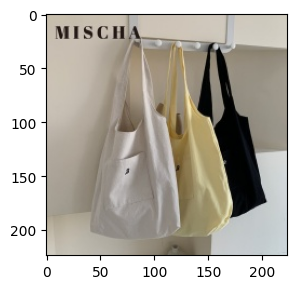

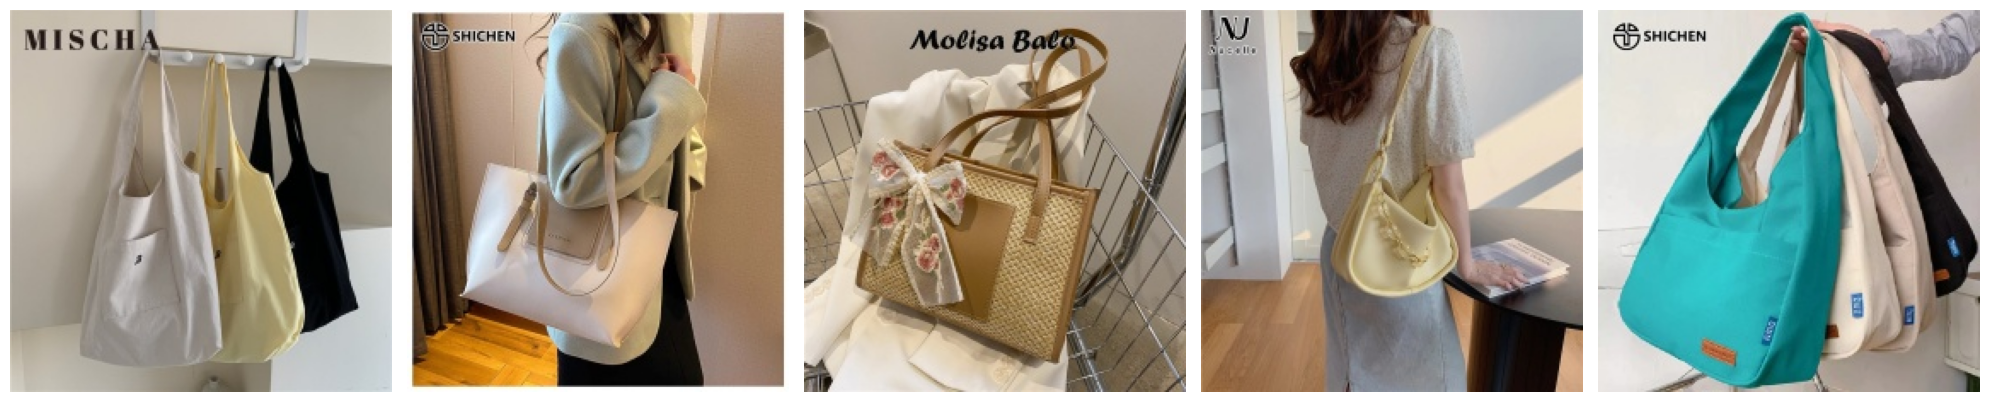

In [10]:
draw_images(df_match, 2999787165)

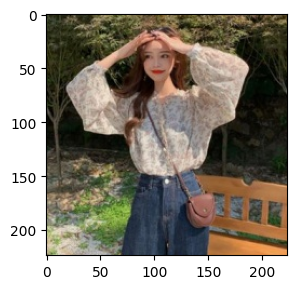

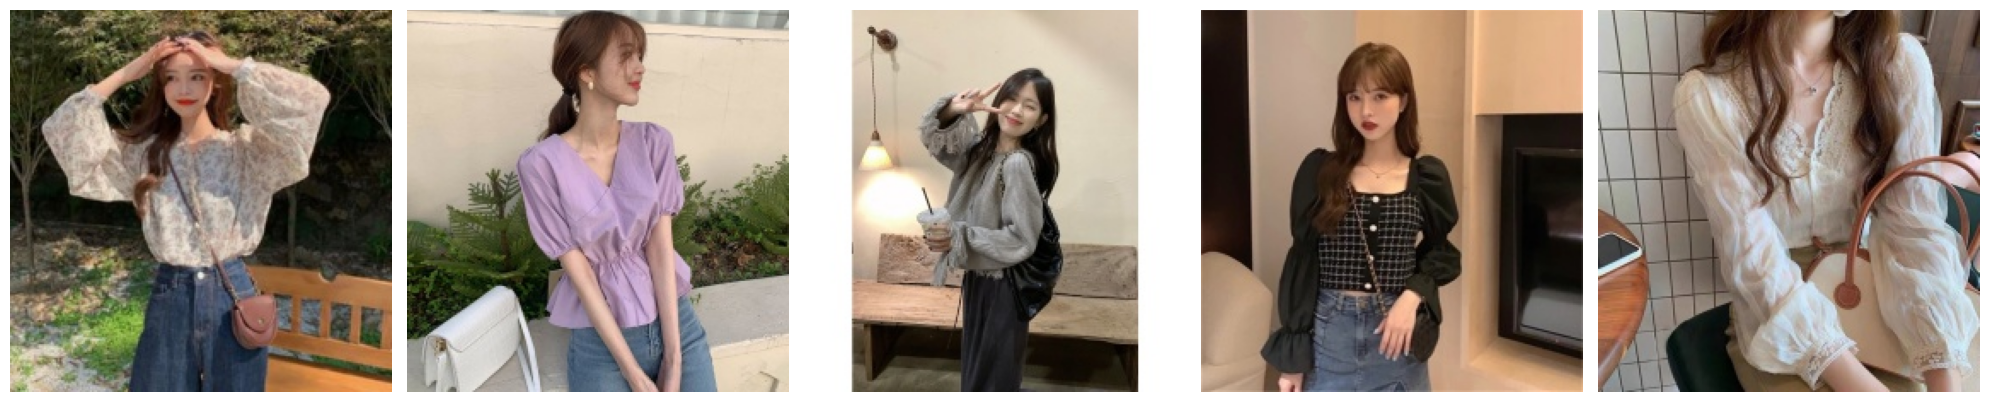

In [11]:
draw_images(df_match, 3099789245)

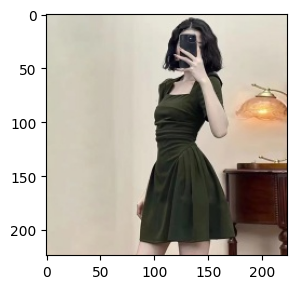

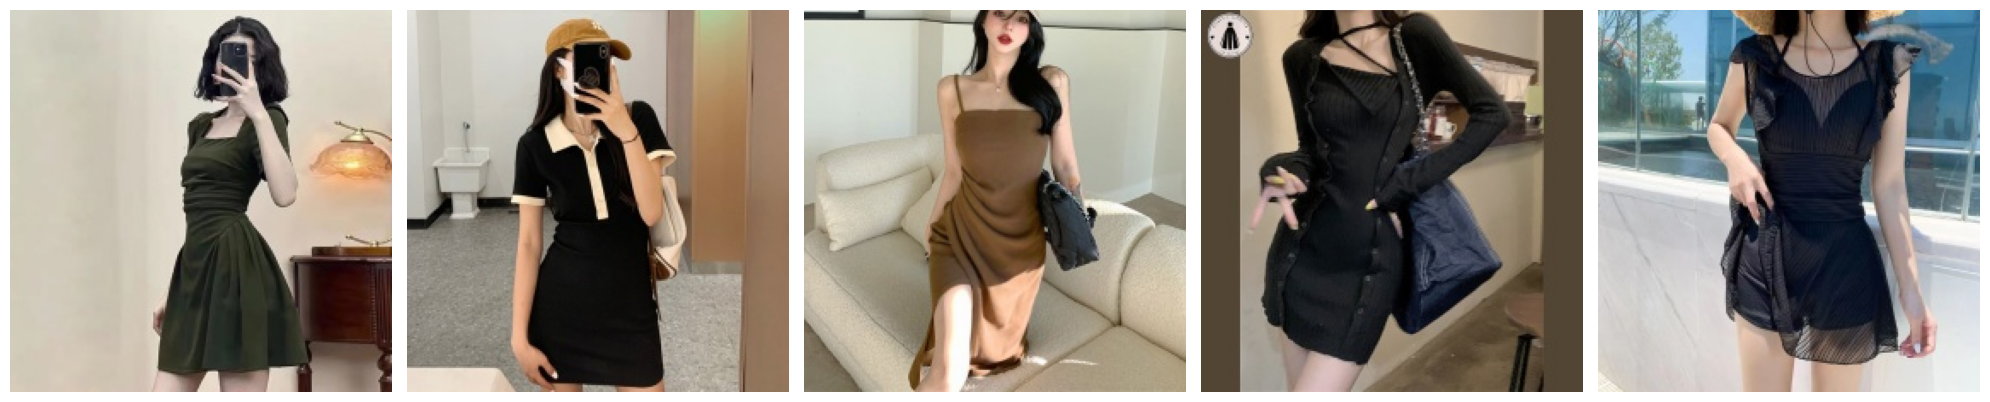

In [12]:
draw_images(df_match, 2999838844)

IndexError: index 5 is out of bounds for axis 0 with size 5

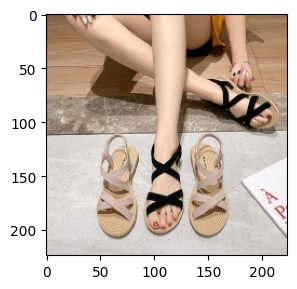

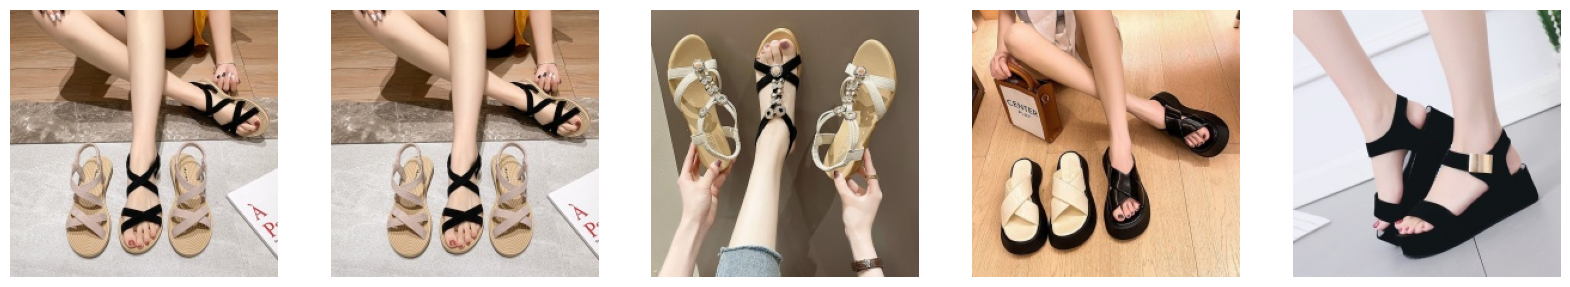

In [13]:
draw_images(df_match, 3099458499)

In [ ]:
# df_match.write_csv(path / 'match.csv')